In [120]:
import pygmt
import numpy as np
import os
import pandas as pd
from pyrocko import util, model, io, trace, gmtpy
import pyrocko.moment_tensor as pmt
from pyrocko.plot import beachball
import matplotlib.pyplot as plt

workdir='../'
catdir =  os.path.join(workdir,'CAT')

switch_VLP=False         ###SWITCH###

if switch_VLP:
    clustydir='../../clusty_flegrei/results_VLP'    
else:
    clustydir='../../clusty_flegrei/results_VT'   

clusty_filename= os.path.join(clustydir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')  ###CHANGE###
           
clusty_events = model.load_events(clusty_filename)

### Open clusty results

In [121]:
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev.extras['color'])

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev.moment_tensor)

if not switch_VLP:
    del cls[-1]     #remove ev not clustered, only for VT

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')

cluster 0 with n ev = 13
cluster 2 with n ev = 4
cluster 1 with n ev = 15
cluster 4 with n ev = 4
cluster 3 with n ev = 4
cluster 5 with n ev = 5
cluster 6 with n ev = 5


### KAGAN moment tensor for each cluster VT

In [122]:
switch_calculate_kagan=False                            ###SWITCH###                       

if switch_calculate_kagan:

    cls_ev = {key: [] for key in cluster_number}
    for ev in clusty_events:
        cls_ev[ev.extras['cluster_number']].append(ev)
    del cls_ev[-1] 
    
    kagan_score_clusters= {key: [] for key in cluster_number}
    del kagan_score_clusters[-1] 
    for key in kagan_score_clusters:
        for ev1 in cls_ev[key]:
            total=0
            n_ev=1
            for ev2 in cls_ev[key]:
                total += pmt.kagan_angle(ev1.moment_tensor, ev2.moment_tensor)
                n_ev += 1
            kagan_score_clusters[key].append( [ [ev1.name ] , [ total/n_ev ] ] )
        kagan_score_clusters[key].sort(key=lambda x: x[1], reverse=False)
    
    for key in kagan_score_clusters:
        print(f'for cluster {key} the event selected is {kagan_score_clusters[key][0][0]} with kagan value :{kagan_score_clusters[key][0][1]}')

for cluster 0 the event selected is ['flegrei_2023_10_02_20_08_26'] with kagan value :[35.974743822634174]
for cluster 2 the event selected is ['flegrei_2023_10_16_10_36_21'] with kagan value :[27.826264926272597]
for cluster 1 the event selected is ['flegrei_2023_06_15_15_39_40'] with kagan value :[29.390214122734708]
for cluster 4 the event selected is ['flegrei_2024_04_06_11_59_31'] with kagan value :[14.043123852897049]
for cluster 3 the event selected is ['flegrei_2023_03_13_22_40_53'] with kagan value :[13.938431368381824]
for cluster 5 the event selected is ['flegrei_2023_09_27_01_35_34'] with kagan value :[32.992366736413246]
for cluster 6 the event selected is ['flegrei_2024_01_21_09_35_04'] with kagan value :[28.327185531083142]


### manually adding Kagan events to new catalogue, then open it

In [123]:
if switch_VLP:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan_VLP.pf')
else:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan.pf')

cat_kagan=model.load_events(cat_kagan_filename)

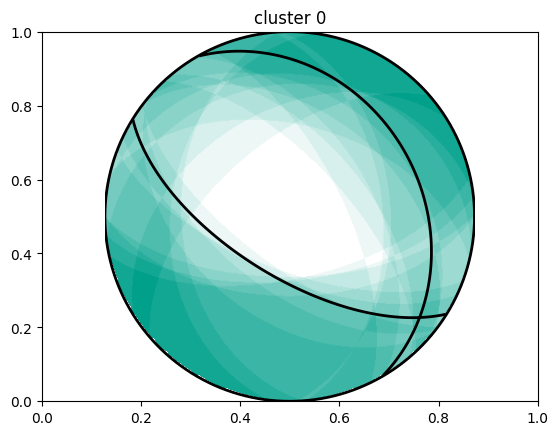

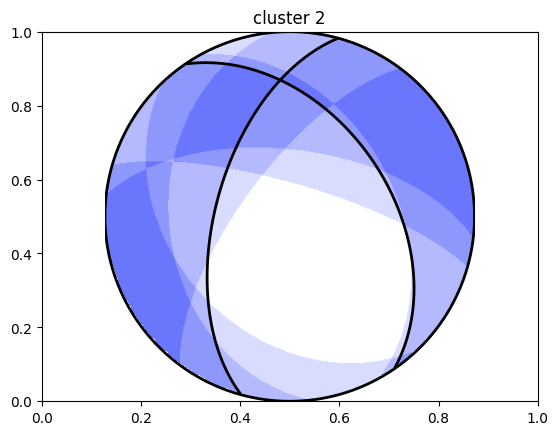

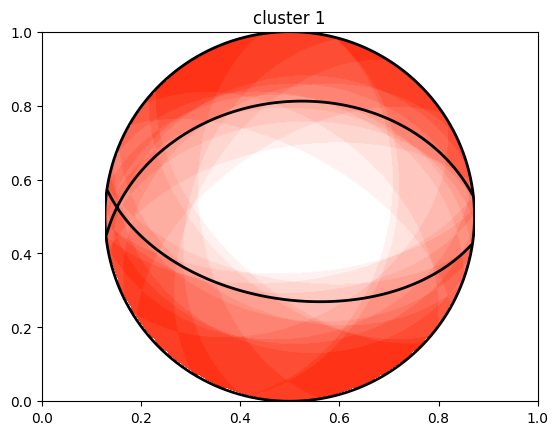

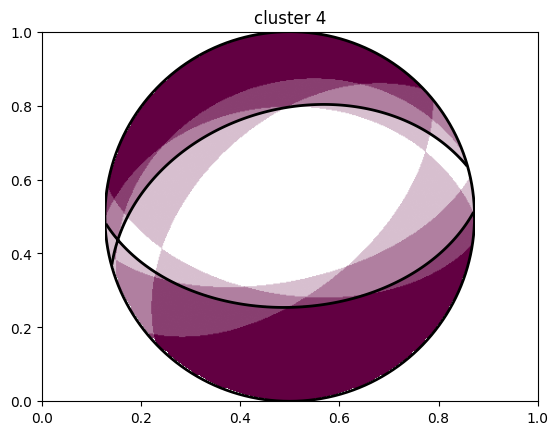

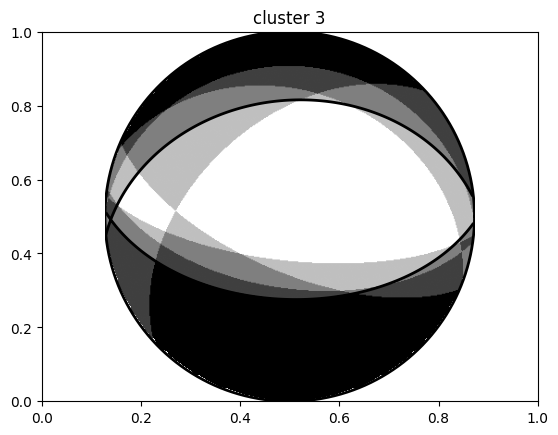

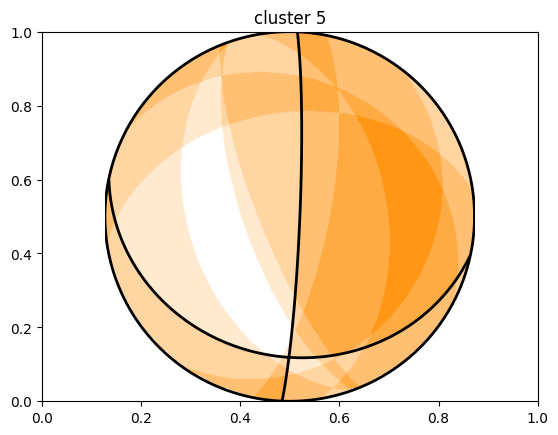

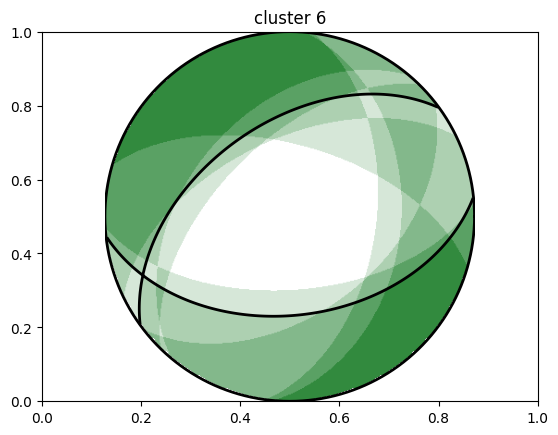

In [124]:
for i,keys in enumerate(cls):
    fig = plt.figure()
    plt.title(f'cluster {keys}')
    axes = fig.add_subplot(1, 1, 1, aspect=1.)
    axes.axison = False
    beachball.plot_fuzzy_beachball_mpl_pixmap(cls[keys], axes, best_mt=cat_kagan[i].moment_tensor, 
        beachball_type='dc', 
        color_t=cluster_color[i], color_p='white', 
        edgecolor='black', best_color='black', linewidth=2, 
        alpha=1.0,grid_resolution=400)
#    beachball.plot_fuzzy_beachball_mpl_pixmap(cls[keys], axes, best_mt=None, 
#        beachball_type='dc', position=(0.0, 0.0), 
#        size=None, zorder=0, color_t='red', color_p='white', 
#        edgecolor='black', best_color='red', linewidth=2, 
#        alpha=1.0, projection='lambert', size_units='data',
#        grid_resolution=400, method='imshow', view='top')
    

# Percentage of DC component

In [127]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final.pf')

cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- CLVD : {ratio_clvd*100:3.3}%')
print(f'total events with non CD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2019_12_06_00_17_23 --- non DC : 54.4% --- CLVD : 54.4%
flegrei_2022_03_29_17_45_32 --- non DC : 79.8% --- CLVD : 79.8%
flegrei_2023_02_05_00_45_36 --- non DC : 64.5% --- CLVD : 64.5%
flegrei_2023_05_08_02_28_34 --- non DC : 65.2% --- CLVD : 65.2%
flegrei_2023_09_12_02_28_50 --- non DC : 53.3% --- CLVD : 53.3%
flegrei_2023_09_26_07_10_29 --- non DC : 56.1% --- CLVD : 56.1%
flegrei_2023_10_04_08_46_55 --- non DC : 60.1% --- CLVD : 60.1%
flegrei_2023_11_23_18_41_46 --- non DC : 92.9% --- CLVD : 92.9%
flegrei_2024_02_17_18_09_50 --- non DC : 69.0% --- CLVD : 69.0%
flegrei_2024_04_04_05_14_36 --- non DC : 58.6% --- CLVD : 58.6%
flegrei_2024_04_14_07_57_58 --- non DC : 60.3% --- CLVD : 60.3%
flegrei_2024_04_14_08_01_43 --- non DC : 69.2% --- CLVD : 69.2%
flegrei_2024_04_27_03_44_56 --- non DC : 51.7% --- CLVD : 51.7%
flegrei_2024_05_20_19_55_37 --- non DC : 79.9% --- CLVD : 79.9%
flegrei_2024_05_22_06_28_00 --- non DC : 53.8% --- CLVD : 53.8%
flegrei_2024_05_25_01_03_23 --- non DC :

In [130]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL.pf')
cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- ISO : {ratio_iso*100:3.3}%  --- CLVD (difference) : {ratio_clvd*100:3.3}%')
print(f'total events with CLVD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2019_10_05_05_08_37 --- non DC : 70.5% --- ISO : 4.03%  --- CLVD (difference) : 66.4%
flegrei_2019_12_06_00_17_23 --- non DC : 88.2% --- ISO : 0.577%  --- CLVD (difference) : 87.6%
flegrei_2023_01_19_08_44_30 --- non DC : 86.5% --- ISO : 30.2%  --- CLVD (difference) : 56.3%
flegrei_2023_03_04_13_15_20 --- non DC : 89.2% --- ISO : 35.5%  --- CLVD (difference) : 53.7%
flegrei_2023_04_23_00_35_20 --- non DC : 81.1% --- ISO : 19.7%  --- CLVD (difference) : 61.5%
flegrei_2023_05_08_02_28_34 --- non DC : 83.3% --- ISO : 23.5%  --- CLVD (difference) : 59.8%
flegrei_2023_05_08_22_33_17 --- non DC : 72.6% --- ISO : 11.9%  --- CLVD (difference) : 60.6%
flegrei_2023_08_18_04_09_59 --- non DC : 85.1% --- ISO : 22.1%  --- CLVD (difference) : 63.0%
flegrei_2023_10_04_08_46_55 --- non DC : 64.7% --- ISO : 5.05%  --- CLVD (difference) : 59.6%
flegrei_2023_10_16_10_36_21 --- non DC : 58.7% --- ISO : 1.06%  --- CLVD (difference) : 57.6%
flegrei_2024_02_17_18_09_50 --- non DC : 80.3% --- ISO : 21

# Catalogue with deviatoric components of the FULL inversions

In [106]:
from pyrocko import moment_tensor, orthodrome
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL.pf')
cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    #(moment_iso, ratio_iso, m_iso)=decomposition[0]
    #(moment_dc, ratio_dc, m_dc)=decomposition[1]
    #(moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]
    #print(ev.moment_tensor.__dict__)
    mtdevi=moment_tensor.MomentTensor(m_devi)
    ev.moment_tensor = mtdevi
    #print(ev.moment_tensor.__dict__ ,'\n')

cat_filename_devi=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL_devi.pf')
model.dump_events(cat, cat_filename_devi)
